## Project Description

The aims of this project is to classify elements of a list of named entities males, females or businesss of specific types. For example, "John Smith" would be classified as a male and "Johnson and Fowler Car Washing" would be classified as a partnership in an ideal world. While this may seem like an arbitrary classification task, its goal is to engineer features for another project. The project in question attempts to predict the probability of entities (e.g. homeowners, landlords or businesses) complying with fines for failing to maintain the appearance of their properties in Detroit. This is useful because it gives the city better information about which violators it should focus its resources on when chasing fines. One of the features in the dataset for this project is the violator's name. Unfortunately, there is no type associated with these names. That is, there is no indication as to whether "Jane Doe" is a female or a multinational corporation, even though an entity's type is likely to be highly informative about whether or not it is likely to comply with a fine. As a result, a highly accurate model for classifying entities based solely on short strings of text (the names) is likely to be of use for the predictive success of the project. Manually labelling the features is not feasible because there are circa 200,000 rows.

A carefully designed neural network might achieve superhuman success in this task. Without domain specific knowledge, it is unlikely that a person will be able to separate businesses into highly specific categories as well as a high performance network can. However, in the case of determining gender from names even a relatively sophisticated model might not outperform people. Virtually everyone has domain specific knowledge in determining gender from names. We do it all the time in our day to day life. It is also extremely difficult for a model to generalise to unseen data to determine gender because, in many cases, the "rules" that determine whether an individual is male or female are violated. In addition, in some cases it is impossible to predict name from gender with high probability because of unisex names. Given relatively limited training data (explained below), this means our expectations should be somewhat tempered when it comes to categorising people as male or female. Humans can rely on their vast experience to identify exceptions to rules, something a neural network may not be able to do given the limited size of our training data (explained below).

## Datasets

The ambitious nature of the task at hand is further amplified by the fact that the training data is unlikely to be representative of the actual data we want to predict on. The data we want to predict on contains (for the most part) both first names and last names for cases in which the violating entities are people. Since the data to predict on has a mixture of entity types with no labels, it is not possible to eliminate last names from the dataset. Because of the lack of labels, doing so would also delete important tokens from non name entities. It was therefore necessary to source data containing both first and last names along with their gender labels. This naturally limited the size and representativeness of the training dataset. In the end, data from US prison inmates was used for names. This data is limited in size and is unlikely to be representative of the Detroit blight violator population as a whole for many reasons, including the fact that the inmate population is not representative of society at large.

The training data for business names comes from Iowa, where there may be subtle naming convention differences compared to Detroit. The data contains the names of registered businesses and their types. All of the data issues mentioned thus far are likely to reduce the ability of the model to generalise to the data to predict on. Performance on the unseen test set will therefore be an overestimate of performance in the application that matters for our problem.

Generalisation performance will be made more difficult still by formatting issues. For example, some of the name strings in the data we want to predict on contains middle names and some don't. It is not possible to remove middle names because we don't have labels for which entities are people and which are businesses. It is therefore difficult to train on data of the same format of the names we actually see in practice. This is a big issue, since if we remove middle names from the training data, the model may simply predict that entities with more than two words are businesses. On the contrary, if we don't remove middle names, there may be insufficient training examples of names with no middle name, in which case any name with only two words in the dataset may be predicted to be a business. The solution used here involved inserting a random letter to indicate the presence of a middle name into the training data. This is an imperfect solution for a number of reasons, but should work well to combat the issues outlined above.

## Model Architecture

This architecture of this model was inspired by a 2017 paper used to determine nationalities from names. The model creates character level unigram, bigrams and trigram sequences from names, learns word embeddings from the tokens in these sequences and passes the embedded sequences into three separate LSTM networks, the results of which are concatenated and passed through a dense layer to determine the class of each word. More details of the approach used can be found in the paper or by following along with the project here. The paper used for inspiration and a source for adaptation can be found at the following link:

https://www.ijcai.org/proceedings/2017/0289.pdf

Note that there are multiple differences from the paper in the Keras adapted version used here, but these are not overly important.

## Model Performance

Although we don't have labels for the column to predict on, simple observation of a medium size sample shows that the model performs relatively poorly. A very high proportion of data points can easily be identified by a human as misclassified, despite the very good performance on an unseen test set. Ultimately, converting the column using this classifier was not able to improve performance on the blight prediction task and so was not used. This is likely due to all of the issues outlined above, which made the project extremely ambitious. Hyperparameter tuning was not carried out due to limitations in both time and computing power but also because it is unlikely that it would have improved matters: the base level performance was fairly good but the performance on the application data was far worse, thus indicating that the problems above were somewhat insurmountable.

Despite difficulties engineering useful features in practice with this model, the project proved useful in demonstrating how to adapt concepts from an academic paper into a Keras multi input neural network. Though the network in the 2017 paper aimed to identify nationality from names, the strong performance of a similar model on the test set here in a different problem domain demonstrates the usefulness of the methods and shows that the concepts used are likely applicable to many other text classification problems. The lack of success in generating useful features likely stems from the very specific nature of the underlying data to predict on and an inability to find similar training data. The model itself, however, is very successful. To demonstrate the usefulness of the model, its performance is compared with a simplistic out of the box gradient boosting model. Though no complex feature engineering or tuning was carried out on the gradient boosting model, the difference in performance is a strong indicator that the complex model is a good idea, especially given that tuning often does little for performance in a gradient boosting model.

## Data Preprocessing and Exploration

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from numpy import array
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Dense, Embedding, Dropout, Concatenate, Activation, Input, CuDNNLSTM
from keras.callbacks import EarlyStopping
import numpy as np
import keras

# Set seed values to get reproducible results with Keras
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

Using TensorFlow backend.


In [54]:
# Create dataframes for the following CSV files.
businesses = pd.read_csv('Active_Iowa_Business_Entities.csv')
black_female = pd.read_csv('Black-Female-Names.csv')
black_male = pd.read_csv('Black-Male-Names.csv')
hispanic_female = pd.read_csv('Hispanic-Female-Names.csv')
hispanic_male = pd.read_csv('Hispanic-Male-Names.csv')
white_female = pd.read_csv('White-Female-Names.csv')
white_male = pd.read_csv('White-Male-Names.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [55]:
# We only want input and target variables from the businesses dataframe. Rename these to name 
# and type for concatenation with the names dataset.
businesses = businesses[['Legal Name', 'Corporation Type']]
businesses.columns = ['name', 'type']

# Determine the size of each group. For small groups there may not be enough data to learn a mapping from names to business type.
# In such cases we will create composite groups.
businesses.groupby('type').size()

type
CO-OP NON STOCK                                             139
CO-OP NON-PROFIT                                              2
CO-OP PROFIT                                                  2
CO-OP STOCK                                                 120
CO-OP STOCK VALUE ADDED                                      13
COUNTY AND CITY AUTHORITY                                     5
COUNTY GENERAL PARTNERSHIP                                    3
DOMESTIC BANKS                                              328
DOMESTIC COOPERATIVE                                         20
DOMESTIC LIMITED LIABILITY COMPANY                       112495
DOMESTIC LIMITED LIABILITY LIMITED PARTNERSHIP              512
DOMESTIC LIMITED LIABILITY PARTNERSHIP                     2765
DOMESTIC LIMITED PARTNERSHIP                               1454
DOMESTIC PROFESSIONAL                                      3082
DOMESTIC PROFESSIONAL LIMITED LIABILITY COMPANY            1368
DOMESTIC PROFIT                    

In [56]:
# As we can see, there are many groups. Such granularity is unecessary for our purposes. Furthermore, for some groups there
# aren't lots of data points to learn accurate mappings from name to type with a deep learning model. We will therefore form 
# composite groups from similar types. Since similar types have similar type names, it is a good idea to first create a sorted
# list of the groups. This will make forming composite groups using list indices much easier.

# Create a sorted list of business types.
a = sorted(list(set(businesses['type'].values)))
# Print a list of types and their associated indices in the sorted list.
for i, j in enumerate(a):
  print(i,j)

0 CO-OP NON STOCK
1 CO-OP NON-PROFIT
2 CO-OP PROFIT
3 CO-OP STOCK
4 CO-OP STOCK VALUE ADDED
5 COUNTY AND CITY AUTHORITY
6 COUNTY GENERAL PARTNERSHIP
7 DOMESTIC BANKS
8 DOMESTIC COOPERATIVE
9 DOMESTIC LIMITED LIABILITY COMPANY
10 DOMESTIC LIMITED LIABILITY LIMITED PARTNERSHIP
11 DOMESTIC LIMITED LIABILITY PARTNERSHIP
12 DOMESTIC LIMITED PARTNERSHIP
13 DOMESTIC PROFESSIONAL
14 DOMESTIC PROFESSIONAL LIMITED LIABILITY COMPANY
15 DOMESTIC PROFIT
16 DOMESTIC SAVINGS & LOAN
17 FARM CORP (NON REGIST.)
18 FED FEDERAL FILING (NOT UNDER IOWA CHAPTER)
19 FOREIGN COOPERATIVE
20 FOREIGN LIMITED LIABILITY COMPANY
21 FOREIGN LIMITED LIABILITY LIMITED PARTNERSHIP
22 FOREIGN LIMITED LIABILITY PARTNERSHIP
23 FOREIGN LIMITED PARTNERSHIP
24 FOREIGN PROFESSIONAL
25 FOREIGN PROFESSIONAL LIMITED LIABILITY COMPANY
26 FOREIGN PROFIT
27 GENERAL PARTNERSHIP
28 INSURANCE COMPANIES
29 MULTIPLE HOUSING ACT
30 REVISED DOMESTIC NON-PROFIT
31 REVISED FOREIGN NON-PROFIT
32 REVISED UNIFORM UNINCORPORATED NON-PROFIT ASSOC

In [57]:
# When forming composite groups, decisions had to be made about where to place certain businesses that would fit into two 
# categories. For example, there are professional companies that are also limited liability companies. 
# Similarly, there are cooperatives that are also non profits. In such cases, the categorisation decisions reflect what is
# intuitively considered the more important defining factor of the entity type for the likelihood of paying blight fines 
# (which is what this whole project is for, ultimately). For example, the fact that a company is non profit
# is likely more important than the fact that it is a cooperative. 


# Create a composite group of non-profits.
non_profit = a[30:] + [a[1]]
# Create a composite group of limited liability companies.
limited_liability = a[9:13] + [a[14]] + a[20:24] + [a[25]] 
# Create a composite group of cooperative companies
coop = [a[0]]+a[2:5]+[a[8]]+[a[19]]
# Multiple housing act (residential cooperative) composite group.
housing = [a[29]]
# Banks, insurance companies and savings and loan institutions composite group
finance = [a[7]] + [a[28]] + [a[16]]
# Domestic profit composite group
domestic_profit = [a[15]]
# Foreign profit composite group
foreign_profit = [a[26]]
# Professional (group domestic and foreign as foreign is a small group) composite group
professional = [a[24]]+[a[13]]
# Partnership composite group
partnership = [a[27]]+[a[6]]



# Other (not enough data points to form single groups, not enough similarity with other groups to form composite groups).
# County and city authority, farm corps, fed filing etc fit into other. Note this is a very small composite group, creating very
# imbalanced classes. The model may fail to learn this group and simply fit members into a larger class since predicting
# large classes by default can reduce training loss, which backpropagation tries to minimise.
non_other = non_profit + limited_liability + coop + housing + finance + domestic_profit + foreign_profit + professional + partnership
other = [i for i in a if i not in non_other]

# Re label types in the businesses dataframe to reflect composite groupings.
businesses.replace(non_profit, 'non profit', inplace = True)
businesses.replace(limited_liability, 'limited liability', inplace = True)
businesses.replace(coop, 'coop', inplace = True)
businesses.replace(housing, 'housing', inplace = True)
businesses.replace(finance, 'finance', inplace = True)
businesses.replace(domestic_profit, 'domestic profit')
businesses.replace(foreign_profit, 'foreign profit', inplace = True)
businesses.replace(professional, 'professional', inplace = True)
businesses.replace(partnership, 'partnership', inplace = True)
businesses.replace(other, 'other', inplace = True)
                                
# Check the number of items in each of the composite types.
businesses.groupby('type').size()



type
DOMESTIC PROFIT       54533
coop                    295
finance                 466
foreign profit        15297
housing                1166
limited liability    130831
non profit            30181
other                    17
partnership             184
professional           3355
dtype: int64

In [0]:
# Some groups are very small to the extent that it may be hard to learn a mapping. It is likely that the model will simply
# predict a larger class for these small groups because the model simply tries to reduce loss. Since the loss from predicting 
# wrong on a small group is small, defaulting to predicting a larger class is easier. Nevertheless, we will see how the model
# performs. We will reduce some of the largest groups in size, which will both balance the classes to some extent, thus partially
# solving the imbalanced class problem. However, the main reason for doing this is to save on training time,
# which is important given that we will use a complex concatenated LSTM model. However, we will not balance 
# the classes completely as we want enough training data to distinguish between groups.

# Since we have created composite groups, before reducing group size we will want to randomly shuffle rows so that 
# we get members from each of the sub-groups. 

businesses = businesses.sample(frac=1).reset_index(drop=True)

businesses_domestic_profit = businesses[businesses['type']=='domestic profit'].head(5000)
businesses_llc = businesses[businesses['type']=='limited liability'].head(5000)
businesses_non_profit = businesses[businesses['type']=='non profit'].head(5000)
businesses_foreign_profit = businesses[businesses['type']== 'foreign profit'].head(5000)

# Create a dataframe containing only the types whose group sizes weren't cut above. This will be used for concatenation below
# to create the businesses part of the training dataframe.
# Drop the 'other' variable. The number of training examples is too low. In any case,
# it is not particularly important we classify these correctly for performance given the rarity of these types of business
# (which will likely also be the case in the blight data to predict on).
businesses2 = businesses[businesses.type.isin(['finance', 'partnership', 'professional', 'housing', 'coop',])]



businesses = pd.concat([businesses_non_profit, businesses_llc, businesses_domestic_profit, businesses_foreign_profit, businesses2])

In [0]:
# Group into males and females. Categorising by ethnicity was tried with some success, 
# but the drop in performance probably isn't worth it for the additional granularity. The results aren't 
# accurate enough. Deep learning gender from names is difficult enough but is especially difficult when there are surnames,
# small non representative sample sizes and the additional need to separate names from other categories too.

# First, we need to rename the columns of the names dataframes so that they are all the same for concatenation.

black_female.columns = ['last_name', 'first_name', 'gender', 'race']
hispanic_female.columns = ['last_name', 'first_name', 'gender', 'race']
white_female.columns = ['last_name', 'first_name', 'gender', 'race']

black_male.columns = ['last_name', 'first_name', 'gender', 'race']
hispanic_male.columns = ['last_name', 'first_name', 'gender', 'race']
white_male.columns = ['last_name', 'first_name', 'gender', 'race']

males = pd.concat([white_male, black_male, hispanic_male])
females = pd.concat([white_female, black_female, hispanic_female])

# The inmates dataset contains many repeats of first names. Since first name is predictive of gender, we don't want repeats.
# If we have repeats, then we will get an overestimate of generalisation performance because the same names will occur in
# both the train and test sets, resulting in the model simply memorising some names. We solve that problem here by ensuring
# only once occurence of each first name for both males and females.
females['first_name'] = females['first_name'].str.split().str.get(0)
a = females.groupby('first_name').first()
females = pd.DataFrame({'last_name': a['last_name'], 'first_name': a.index, 'type': 'female'})


males['first_name'] = males['first_name'].str.split().str.get(0)
b = males.groupby('first_name').first()
males = pd.DataFrame({'last_name': b['last_name'], 'first_name': b.index, 'type': 'male'})

In [0]:
# Resample the males dataset with a random order
males = males.sample(frac = 1, random_state = 7).reset_index(drop = True)

# Make the length of the ales dataset the same as for females. Without doing this, it was found that the class imbalance between
# males and females causes the neural network to classify too many females as males. This is not surprising. Since males and
# females are similar entities in terms of their text features and are therefore hard to seaparate,
# the model may default to often picking the majority class as a consequence of trying to maximise accuracy through backpropagation.

males = males.head(len(females))



In [0]:
# Since the data we wish to predict on in the column from the blight project contains both first and last names, we must have both first and last names in the training dataset, even though last names
# are unlikely to be a useful predictor for gender.
# It is not possible to delete last names from the data we want to predict on because there are other entities in this column that aren't people. Since there are no labels we can't selectively
# delete certain words. Removing last names will also remove informative features from other entities. Note we want the last name to appear first, then the first name. This is how names appear in
# the data to predict on. We also want to insert a random alphabetic letter after some names to reflect the presence of a middle name in some of the data to predict on. If we don't do this, then the model
# might predict any person with a middle name (i.e more than 2 words) to be a non person entity. Again, we can't delete the middle name indicator from the data to predict on because there are no entity type
# labels.


import string
import random



males['name'] = males['last_name']+' '+males['first_name']
males['type'] = 'male'
# We only want the following columns, consistently labelled for concatenation with another dataframe.
males = males[['name', 'type']]
# Add a random alphabetic character to a fixed proportion of the names to reflect the presence of a middle name in the data to predict on. Use 50% to force the model to identify name features rather than
# just identifying the number of words. If we only use a low percentage, say 10%, the cost of the model predicting all names with middle names to be another type would be low.


dfupdate = males.sample(frac=.5, random_state = 2)
indvals = dfupdate.index
vect = dfupdate['name'].values
vect=[val+' '+random.choice(string.ascii_lowercase) for val in vect]
dfupdate['name'] = pd.Series(vect, indvals)
males.update(dfupdate)

# Same as above.
females['name'] = females['last_name']+ ' ' + females['first_name']
females['type']='female'
females = females[['name','type']]

dfupdate2 = females.sample(frac=.5, random_state = 3)
indvals2 = dfupdate.index
vect2 = dfupdate['name'].values
vect2 = [val+' '+random.choice(string.ascii_lowercase) for val in vect2]
dfupdate2['name'] = pd.Series(vect2, indvals2)
females.update(dfupdate2)

# Concatenate.
names_and_businesses = pd.concat([businesses, males, females], ignore_index = True)






In [0]:
# lowercase (not actually necessary as this is handled by Keras Tokenizer later)
names_and_businesses['name'] = names_and_businesses['name'].str.lower()  
# Shuffle dataset so that when results are visualised we can see names and business classifications together.
names_and_businesses = names_and_businesses.sample(frac=1).reset_index(drop=True)
# Replace multiple spaces with single spaces.
names_and_businesses['name'] = names_and_businesses['name'].str.replace(r'\s+', ' ')
names_and_businesses['name'] = names_and_businesses['name'].str.strip()
X = names_and_businesses['name']
y = names_and_businesses['type']

In [0]:
# Create a train test split of the data for validation
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 4)

In [0]:
# Create copies of the training and test dataframes. This will be useful if we want to combine predictions (ensembling).
# We want to train models separately but use the same train test split.
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

## Simple Benchmark Model

First, let's establish a baseline level of performance with a simple out of the box model. We use gradient boosting because it gives a good out of the box baseline performance without complex feature engineering or hyperparameter tuning. In most cases, hyperparameter tuning will not result in a large increase in performance for gradient boosting with default parameters. We don't hypertune here to save time and computation, but it is hoped that our neural network model achieves significantly higher performance than this baseline.

In [66]:
# Here, we generate simple features.
# Features are of the form first-nletters or last-n letters. We can vary n using the function definition. A dict comprehension
# is used within the function so we can vary the number of features easily. Since the average length of the string input is 21,
# we go up to the first and last 15 letters such that there are 30 features in total. This captures most of each string from
# both directions and is probably more than necessary. It also increases training time but since training doesn't take long for gradient
# boosting we will use this number to start with.


def features(name, n=15):
    '''Function to generate features from a string.
    
    (str, int)->dict
    
    >>> features('Josie Wales', 3)
    {'first-letter': 'J', 'first2-letters': 'Jo', 'first3-letters': 'Jos', 'last-letter': 's', 'last2-letters': 'es', 
    'last3-letters': 'les'}
    '''
  # lower case the name
  name = name.lower()
  # Create a list of keys that are the names of the first n features.
  first_letter = ['first-letter']
  first_n_letters = ['first{}-letters'.format(i) for i in range(2,n+1)]
  first_n_letters = first_letter + first_n_letters
  # Create a list of keys for the last n features
  last_letter = ['last-letter']
  last_n_letters = ['last{}-letters'.format(i) for i in range(2,n+1)]
  last_n_letters = last_letter+last_n_letters
  # Concatenate lists to create all keys
  keys = first_n_letters + last_n_letters
  # Create lists of values for the first and last n features, then concatenate to create all values.
  first_letter_value = [name[0]]
  val1 = [name[0:i] for i in range(2,n+1)]
  val2 = [name[-i:] for i in range(1,n+1)]
  # Concatenate
  values = first_letter_value + val1 + val2
  # zip values for performing a dict comprehension
  zipvals = zip(keys, values)
  d = {k: v for k,v in zipvals}
  return d

# Vectorise the features function to make it usable with arrays of data  
features = np.vectorize(features)
# Get features associated with names in train and test arrays
X_train_copy = features(X_train_copy)
X_test_copy = features(X_test_copy)

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

# Create train and test arrays compatible with the gradient boosting classifier by vectorizing the features.
vectorizer = DictVectorizer()
vectorizer.fit(X_train_copy)
X_train_gb = vectorizer.transform(X_train_copy)
X_test_gb = vectorizer.transform(X_test_copy)

from sklearn.ensemble import GradientBoostingClassifier

# Fit the gradient boosting classifier.
clf = GradientBoostingClassifier(verbose = 2)
clf.fit(X_train_gb, y_train, random_state = 5)


      Iter       Train Loss   Remaining Time 
         1       33577.2539            5.13m
         2       29032.9622            5.08m
         3       25799.3748            5.02m
         4       23409.7432            4.99m
         5       21430.2014            4.95m
         6       19842.0431            4.89m
         7       18529.6625            4.82m
         8       17430.7478            4.75m
         9       16550.9011            4.69m
        10       15752.6551            4.64m
        11       15073.7244            4.58m
        12       14448.2037            4.52m
        13       13935.9395            4.47m
        14       13491.0576            4.41m
        15       13076.5937            4.35m
        16       12694.0871            4.31m
        17       12358.0386            4.26m
        18       12058.0674            4.21m
        19       11798.1901            4.16m
        20       11539.9300            4.12m
        21       11327.2304            4.06m
        2

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=5, subsample=1.0, verbose=2,
              warm_start=False)

Normalized confusion matrix
[[3.94e-01 0.00e+00 0.00e+00 9.09e-02 3.18e-01 0.00e+00 0.00e+00 1.97e-01
  0.00e+00 0.00e+00]
 [0.00e+00 8.46e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.27e-01 2.67e-02
  0.00e+00 0.00e+00]
 [8.13e-03 0.00e+00 8.46e-01 8.94e-02 8.13e-03 0.00e+00 0.00e+00 4.88e-02
  0.00e+00 0.00e+00]
 [8.09e-04 2.43e-03 8.09e-04 9.47e-01 8.09e-04 0.00e+00 5.66e-03 3.64e-02
  0.00e+00 5.66e-03]
 [1.97e-02 9.84e-03 3.28e-03 4.26e-02 8.92e-01 0.00e+00 6.56e-03 2.62e-02
  0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 8.06e-04 0.00e+00 9.95e-01 1.61e-03 1.61e-03
  8.06e-04 0.00e+00]
 [0.00e+00 1.46e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 8.25e-01 2.86e-02
  0.00e+00 0.00e+00]
 [7.96e-04 2.86e-02 3.18e-03 1.93e-01 5.57e-03 7.96e-04 5.81e-02 7.09e-01
  7.96e-04 0.00e+00]
 [0.00e+00 4.08e-02 0.00e+00 0.00e+00 0.00e+00 1.02e-01 6.12e-02 1.22e-01
  6.73e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 4.86e-03 0.00e+00 1.22e-02 3.65e-03 9.72e-03
  0.00e+00 9.70e-01]]


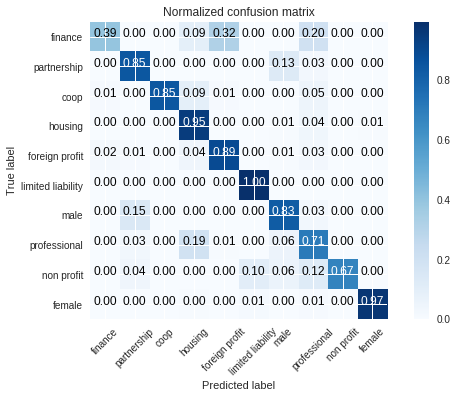

In [67]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot a normalised confusion matrix to give a visual idea of performance. Since we have no idea of the distribution of the
# categories in the column we wish to predict on, we don't know which values are more important to classify well and where 
# misclassification is more costly. While we could make guesses about this, as a first approximation it is easier to
# use average accuracy across all categories with each category weighted equally as the preferred performance metric.
# That is, the average of the values in the leading diagonal of the matrix.

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Get class names
class_names = list(set(y.values))
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, clf.predict(X_test_gb))
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [68]:
# Average accuracy with equal weight for each class (given that we don't know the distribution of classes in the blight violator
# names data to predict on, there is no obvious resason to give more importance to any particular class, so this is as good a measure
# as amy for a first approximation)
np.trace(cnf_matrix.astype('float') /cnf_matrix.sum(axis=1)[:, np.newaxis])/len(cnf_matrix)

0.8097296608793592

The default parameters gradient boosting model does fairly well, with particularly strong performance categorising gender from names. However, it is much weaker in other areas. For example, the classifier is poor at identifying finance companies at only 39%.

In [0]:
# Convert y train and y_test labels to one hot encoding for Keras compatibility when training.
onehot_ytrain = pd.get_dummies(y_train)
target_labels_train = onehot_ytrain.columns
y_train = onehot_ytrain.as_matrix()

onehot_ytest = pd.get_dummies(y_test)
target_labels_test = onehot_ytest.columns
y_test = onehot_ytest.as_matrix()

In [0]:
# We need to convert the text to character level unigram, bigram and trigram sequences. The function below can do this by setting the parameter n.
def word2ngrams(text, n=3, exact=True):
    """ Convert text into character ngrams. 
    >>> word2ngrams('hello', n = 2)
    [he, el, ll, lo]"""
    return ["".join(j) for j in zip(*[text[i:] for i in range(n)])]

# Create character level unigram, bigram and trigram sequences of the names and business names
trigrams = X_train.apply(lambda x: word2ngrams(str(x)))
bigrams = X_train.apply(lambda x: word2ngrams(str(x), n = 2))
unigrams = X_train.apply(lambda x: word2ngrams(str(x), n = 1))

trigramstest = X_test.apply(lambda x: word2ngrams(str(x)))
bigramstest = X_test.apply(lambda x: word2ngrams(str(x), n = 2))
unigramstest = X_test.apply(lambda x: word2ngrams(str(x), n = 1))

# Convert lists to array format for efficiency.
trigrams = trigrams.apply(array)
bigrams = bigrams.apply(array)
unigrams = unigrams.apply(array)

trigramstest = trigramstest.apply(array)
bigramstest = bigramstest.apply(array)
unigramstest = unigramstest.apply(array)

# Create a function that adds a separator | to the character level n grams, this will allow us to split on these characters using the keras Tokenizer below.
# That is, it will allow the ngrams to be recognised as tokens. | is used because it does not appear in the names and so will always identify an ngram. If something else,
# that commonly appears in the names was used to split, such as a space, then the wrong ngrams would be identified.
def array_to_string(a):
    s=''
    for i in range(len(a)):
        if i < len(a) - 1:
            s = s +a[i] + '|'
        else:
            s = s + a[i]
    return s

bigrams = bigrams.apply(array_to_string)
trigrams = trigrams.apply(array_to_string)
unigrams = unigrams.apply(array_to_string)

bigramstest = bigramstest.apply(array_to_string)
trigramstest = trigramstest.apply(array_to_string)
unigramstest = unigramstest.apply(array_to_string)

# Note tokenizer filters out some information we want by default. Here we go with the default where virtually all punctuation
# is removed. This can be changed later as punctuation may be informative for business type.

# The num_words argument of the Keras tokenizer specifies the maximum number of words to keep based on word frequency.
# The n most frequent tokens are kept.
# Here we have set it at the maximum number of possible tokens based on the possible combinations of the alphabet plus
# numeric characters, spaces and ' characters, which are retained by
# the Keras tokenizer under default parameters.


# 38 = alphabet + alphanumeric + space + ''
unigram_vocab_size = 39
t1 = Tokenizer(num_words = unigram_vocab_size, split = '|')
t1.fit_on_texts(list(unigrams))
unigram_sequences = t1.texts_to_sequences(list(unigrams))
unigram_sequences_test = t1.texts_to_sequences(list(unigramstest))

# 39**2 = 1521
bigram_vocab_size = 1521
t2 = Tokenizer(num_words = bigram_vocab_size, split = '|')
t2.fit_on_texts(list(bigrams))
bigram_sequences = t2.texts_to_sequences(list(bigrams))
bigram_sequences_test = t2.texts_to_sequences(list(bigramstest))

#59319**3
trigram_vocab_size = 54872
# Most trigrams will not be relevant and won't. Only take the 20000 most frequent to save training time. This is arbitrary but shouldn't matter.
trigram_vocab_size = 20000
t3 = Tokenizer(num_words = trigram_vocab_size, split = '|')
t3.fit_on_texts(list(trigrams))
trigram_sequences = t3.texts_to_sequences(list(trigrams))
trigram_sequences_test = t3.texts_to_sequences(list(trigramstest))

# calculate the maximum input length
maxlen = names_and_businesses['name'].str.len().max()

# pad documents to a maximum length.
max_length_unigram = maxlen
X_train_unigram = pad_sequences(unigram_sequences, maxlen = max_length_unigram, padding = 'post')
X_test_unigram = pad_sequences(unigram_sequences_test, maxlen = max_length_unigram, padding = 'post')
# 125//2 + 1
max_length_bigram = (maxlen//2) + 1
X_train_bigram = pad_sequences(bigram_sequences, maxlen = max_length_bigram, padding = 'post')
X_test_bigram = pad_sequences(bigram_sequences_test, maxlen = max_length_bigram, padding = 'post')
# 125//3 + 1
max_length_trigram = (maxlen//3)+1
X_train_trigram = pad_sequences(trigram_sequences, maxlen = max_length_trigram, padding = 'post')
X_test_trigram = pad_sequences(trigram_sequences_test, maxlen = max_length_trigram, padding = 'post')





In [71]:
# Keras requires the training data to be divisible by the batch size, so we will delete the remainder from the training data
# to ensure this.
len(X_train_trigram)%32

5

In [0]:
# Batch size is multiple of 32 in the model below. length of training inputs must be divisible by the batch size in keras. Hence we change the length of the inputs. See cell above.
X_train_unigram = X_train_unigram[:-5]
X_train_bigram = X_train_bigram[:-5]
X_train_trigram = X_train_trigram[:-5]
y_train = y_train[:-5]

In [0]:
# The model below is inspired by a 2017 paper used to determine nationalities from names. I adapted it to my categorisation task using Keras using broadly the same framework with minor differences.
# Hyperparameter tuning was not carried out because of a lack of computing resource. Instead, roughly similar paramters to those in the paper are used with good results.

# The paper in question is https://www.ijcai.org/proceedings/2017/0289.pdf

def create_model():
    unigram_input = Input(shape =  (max_length_unigram,))
    # Word embeddings are used to translate large vocabularies into smaller dimensional spaces. For a vocab size of 39 (the number of possible character unigrams here)
    # we are only likely to need a very small embedding to represent the vocabulary, say 4. Having a bigger embedding than necessary will raise training time without value.
    
    # A size 32 word embedding is not necessary to represent such a small number of characters. Save on training time by setting to 4.
    unigram_embedding = Embedding(unigram_vocab_size, 4, input_length = max_length_unigram)(unigram_input)
    # We only want dropout on non recurrent part. This is good because recurrent dropout is not supported with fast implementation
    # CuDNN. Intuitively, the model randomly certain words (as represented by their embeddings) from each sequence of character grams at each training stage to avoid relying too much on 
    # ngrams for prediction. Hence it is a form of regularisation.
    unigram_dropout = Dropout(0.5, noise_shape = (32, max_length_unigram, 1))(unigram_embedding)
    # LSTM has a single layer. LSTM cell size is 200.
    unigram_LSTM = CuDNNLSTM(200)(unigram_dropout)
    
    bigram_input = Input(shape =  (max_length_bigram,))
    # Use more complex embedding (64 dims) to reflect larger vocab
    bigram_embedding = Embedding(bigram_vocab_size, 64, input_length = max_length_bigram)(bigram_input)
    bigram_dropout = Dropout(0.5, noise_shape = (32, max_length_bigram, 1))(bigram_embedding)
    bigram_LSTM = CuDNNLSTM(200)(bigram_dropout)
    
    trigram_input = Input(shape =  (max_length_trigram,))
    # Use more complex embedding (128 dims) to reflect larger number of tokens.
    trigram_embedding = Embedding(trigram_vocab_size, 128, input_length = max_length_trigram)(trigram_input)
    trigram_dropout = Dropout(0.5, noise_shape = (32, max_length_trigram, 1))(trigram_embedding)
    trigram_LSTM = CuDNNLSTM(200)(trigram_dropout)
    
    # Model passes sequences of unigram, bigram and trigram inputs to 3 separate LSTMs, each with 200 hidden units and only a single layer (as in the source paper).
    # The outputs are concatenated and passed to a fully connected layer.
    joined_input = Concatenate()([unigram_LSTM, bigram_LSTM, trigram_LSTM])
  
    out = Dense(10)(joined_input)
    out = Activation('softmax')(out)
    
    model = Model([unigram_input, bigram_input, trigram_input], out)
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    # Use early stopping to save training time when convergence is finished.
    earlystop = EarlyStopping(monitor = 'val_acc', min_delta = 0.001, patience = 10, \
                          verbose = 1, mode = 'auto')
    
    
    callbacks_list = [earlystop]
    
    model.fit([X_train_unigram, X_train_bigram, X_train_trigram], y_train, epochs = 50,
              validation_data = ([X_test_unigram, X_test_bigram, X_test_trigram], y_test), verbose = 2, callbacks =
              callbacks_list)
    
    return model

In [75]:
model = create_model()

Train on 18976 samples, validate on 6327 samples
Epoch 1/50
 - 36s - loss: 0.9577 - acc: 0.6458 - val_loss: 0.4898 - val_acc: 0.8035
Epoch 2/50
 - 35s - loss: 0.5684 - acc: 0.7817 - val_loss: 0.3739 - val_acc: 0.8378
Epoch 3/50
 - 35s - loss: 0.4701 - acc: 0.8113 - val_loss: 0.3311 - val_acc: 0.8668
Epoch 4/50
 - 35s - loss: 0.4213 - acc: 0.8263 - val_loss: 0.3151 - val_acc: 0.8517
Epoch 5/50
 - 35s - loss: 0.3886 - acc: 0.8485 - val_loss: 0.2939 - val_acc: 0.8849
Epoch 6/50
 - 35s - loss: 0.3531 - acc: 0.8706 - val_loss: 0.2848 - val_acc: 0.8864
Epoch 7/50
 - 34s - loss: 0.3227 - acc: 0.8860 - val_loss: 0.2700 - val_acc: 0.8933
Epoch 8/50
 - 35s - loss: 0.3104 - acc: 0.8907 - val_loss: 0.2763 - val_acc: 0.9001
Epoch 9/50
 - 35s - loss: 0.2794 - acc: 0.9028 - val_loss: 0.2538 - val_acc: 0.9044
Epoch 10/50
 - 35s - loss: 0.2649 - acc: 0.9095 - val_loss: 0.2386 - val_acc: 0.9167
Epoch 11/50
 - 35s - loss: 0.2533 - acc: 0.9130 - val_loss: 0.2408 - val_acc: 0.9154
Epoch 12/50
 - 35s - loss

6327/6327 [==============================] - 3s 535us/step
Normalized confusion matrix
[[8.03e-01 0.00e+00 0.00e+00 3.03e-02 1.36e-01 0.00e+00 0.00e+00 3.03e-02
  0.00e+00 0.00e+00]
 [0.00e+00 8.06e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.89e-01 5.01e-03
  0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 9.59e-01 2.44e-02 8.13e-03 0.00e+00 8.13e-03 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 2.43e-03 9.55e-01 0.00e+00 8.09e-04 8.09e-04 3.80e-02
  0.00e+00 3.24e-03]
 [2.95e-02 0.00e+00 3.28e-03 3.28e-03 9.44e-01 0.00e+00 3.28e-03 1.64e-02
  0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 9.96e-01 0.00e+00 8.06e-04
  2.42e-03 8.06e-04]
 [0.00e+00 2.27e-01 0.00e+00 1.59e-03 0.00e+00 1.59e-03 7.60e-01 9.54e-03
  0.00e+00 0.00e+00]
 [0.00e+00 9.55e-03 5.57e-03 7.88e-02 2.39e-03 7.96e-04 6.36e-03 8.95e-01
  7.96e-04 7.96e-04]
 [0.00e+00 4.08e-02 0.00e+00 0.00e+00 0.00e+00 8.16e-02 6.12e-02 8.16e-02
  7.35e-01 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 3.65e-03 0.00e+00 1.22e-02 0.

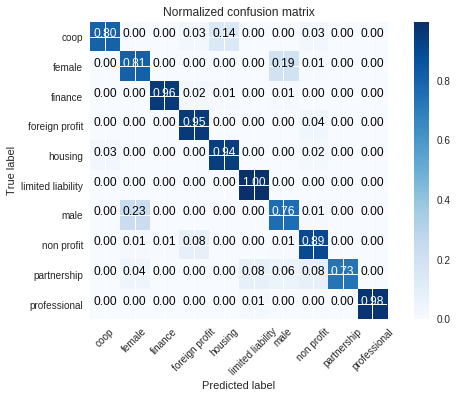

In [76]:
# Get predicted values from model.
one_hot_predictions = model.predict([X_test_unigram, X_test_bigram, X_test_trigram], verbose = 1)
# Convert to label encoding for sklearn
label_encoding_predictions = np.argmax(one_hot_predictions, axis = 1)
label_encoding_test = np.argmax(y_test, axis = 1)

# Get class names
class_names = onehot_ytrain.columns
    
    
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(label_encoding_test, label_encoding_predictions)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [77]:
np.trace(cnf_matrix.astype('float') /cnf_matrix.sum(axis=1)[:, np.newaxis])/len(cnf_matrix)


0.8832608611973386

The model achieves 88% average accuracy without poor performance in any category. This is very encouraging, particularly given that the dataset was reduced to save training time, hyperparameter tuning was not performed and some categories were extremely small e.g. partnerships. This performance on data sets for which there are few samples suggests these classes are relatively easy to identify, which would likely be confirmed in a graphical analysis (e.g. PCA). The model performs far better than the baseline comparison model (gradient boosting). 

## Predictions on Blight Data

Although the unseen test set performance is strong, it is important to note that our training data was not representative. Due to a lack of labels on the data we want to predict, it was not possible to format the training data to match the blight data exactly. Although the lack of labels means we can't get a direct metric for performance, we can use a random sample and see if the classification decisions made match our human intuitions, which is what we do here.

In [0]:
# Import blight df (named train.csv). Perform preprocessing on names so that they can be inputted to the Keras model and use the model to predict entity types.
# Convert predictions from one hot encoding to label encoding. Review performance on a small sample, say 100 values and see if the predictions match human intutions.
# But first randomly sample the column to get a fair representation.

blight = pd.read_csv('train.csv', engine = 'python')

violator_names = blight['violator_name']

# Names should only contain alphabetical characters.
violator_names = violator_names.str.replace(r'([^\s\w]|_)+', '')
# lowercase
violator_names = violator_names.str.lower()  
# Replace multiple spaces with single spaces.
violator_names = violator_names.str.replace(r'\s+', ' ')
# Strip whitespace
violator_names = violator_names.str.strip()

# Convert names into sequences of character level unigrams, bigrams and trigrams.
trigrams = violator_names.apply(lambda x: word2ngrams(str(x)))
bigrams = violator_names.apply(lambda x: word2ngrams(str(x), n = 2))
unigrams = violator_names.apply(lambda x: word2ngrams(str(x), n = 1))

# Convert lists to array format for efficiency.
trigrams = trigrams.apply(array)
bigrams = bigrams.apply(array)
unigrams = unigrams.apply(array)

# Apply array to string funciton. This inserts a separator | between the character level ngrams, which will be used for splitting when applying the Keras Tokenizer defined earlier.
bigrams = bigrams.apply(array_to_string)
trigrams = trigrams.apply(array_to_string)
unigrams = unigrams.apply(array_to_string)

# Create unigram sequences for keras model using keras tokenizer
unigram_sequences = t1.texts_to_sequences(list(unigrams))
# Create bigram sequences.
bigram_sequences = t2.texts_to_sequences(list(bigrams))
# Create trigram sequences.
trigram_sequences = t3.texts_to_sequences(list(trigrams))
# Make all sequences the same length using padding.
X_unigram = pad_sequences(unigram_sequences, maxlen = max_length_unigram, padding = 'post')
X_bigram = pad_sequences(bigram_sequences, maxlen = max_length_bigram, padding = 'post')
X_trigram = pad_sequences(trigram_sequences, maxlen = max_length_trigram, padding = 'post')

# Predict probabilities of each class.
y_prob = model.predict([X_unigram, X_bigram, X_trigram])
# Convert probabilities to class predictions.
y_classes = y_prob.argmax(axis=-1)







In [86]:
# Note that Keras labels the classes alphabetically. Hence if there were a class named 'a' this would be associated with the number 0 in label encoding.
# Using this, we can define a dicitonary mapping numbers to their associated class name.
mydict = {k:v for k,v in zip([i for i in range(10)],sorted(class_names))}

# Convert the labels to class names using the dictionary
labels = np.vectorize(mydict.get)(y_classes)
# Create a comparison dataframe so we can compare the name with the predicted class (entity type). We will view this and see how well the model performs on the
# actual dataset we want to predict on.
comparison = pd.DataFrame({'name': violator_names, 'label': labels})
# We want to view the shuffled comparison dataframe because it is ordered by name so that some entities appear in multiple consecutive rows. We aren't interested
# in predictions on the same data and so we resample.
shuffledcomparison = comparison.sample(frac = 1, random_state = 6).reset_index(drop = True)
# View the first 100 samples so that we can see how the model performs using our human intuition. This is the best we can do to review the performance of the model
# because there are no labels.
shuffledcomparison.head(100)

,label,name
0,female,johnson james
1,female,flowers jay
2,male,thomas frank
3,male,ewing david
4,female,abel lucile
5,male,grice desean jamil
6,male,marcum lenord
7,finance,national assoc us bank
8,non profit,mortgage new century
9,female,hayes elijah


As we can see, peformance is not as good as expected given the performance on the test set. This reflects all the difficulties spelled out in the introduction.

In [87]:
# View the number of predicted values for each type.
shuffledcomparison['label'].value_counts()

female               102237
male                  92557
non profit            22696
limited liability     11664
foreign profit        10870
finance                5430
partnership            3903
housing                 710
coop                    152
professional             87
Name: label, dtype: int64

## Conclusion

The model performs extremely well, especially considering the limitations of the training data. However, it is unable to predict labels for our blight task with sufficient accuracy to improve the predictive power of the blight model. This is not a weakness of the entity recognition model designed here, however. Instead, it reflects the fact that the training data is unrepresentative of the blight names data because the lack of labels in the blight names data means it was impossible to achieve the same formatting for names in the training data.